# ベイズ曲線フィッティング

## 0. 準備編

### 0-1. 基底関数

基底関数とは、「入力変数に関して非線形な関数」です。

### 0-2. 線形基底関数モデル

基底関数を線形結合させた「線形基底関数モデル」は、<br>
・<b>パラメータ(w)に関しては線形</b> ＝ 解析しやすい<br>
・<b>入力変数(x)に関しては非線形</b> ＝ 表現力が高い<br>
という特徴を持つため非常に有用です。
    
基底関数 $\phi$ には、以下の物が使われることが多い。<br>
・$\phi_{j} (\bf{x}) = x_{j} $(線形回帰)<br>
・$\phi_j (x) = x^j$ (多項式回帰)<br>
・ガウシアン関数 → RBFネットワーク、サポートベクターマシン<br>
・シグモイド関数 ($tanh$)<br>
・三角関数 ($sin, cos$) → フーリエ変換<br>
・ウェーブレット関数<br>
・矩形波（矩形関数）、三角波（三角形関数）<br>

### 0-3. 計画行列（デザイン行列）とは

計画行列は、英語では「design matrix」といい、「デザイン行列」「配置行列」とも言います。

多種類の（重）回帰分析、（共）分散分析などの実験計画をモデル化して表すため<br>
に作り出されました。

計画行列 $Φ$ は「基底関数$φ_j(x_n)$ をN行M列に並べたものです。<br>
ここでNは入力（及び目標値）の数、Mはモデルのパラメータ数です。

$φ_0(x_1), φ_1(x_1),..., φ_M-1(x_1)$<br>
$φ_0(x_2), φ_1(x_2),..., φ_M-1(x_2)$<br>
　…　　　　…　　　　　…　　　　<br>
$φ_0(x_N), φ_1(x_N),..., φ_M-1(x_N)　$<br>

基底関数をモデルのパラメータだけ右の列に並べ、<br>
更に入力変数の数だけ下の行に並べた行列であり、<br>
抽象的には<br>
「当該の<b>線形基底関数モデルを行列で表現</b>したもの」<br>
ということ。

ベイズ曲線フィッティングは、完全にベイズ的な取り扱いをすることで曲線をフィッティングする手法です。

最尤推定による予測分布ではどの点についても同じ分散となるのに対して、<br>
ベイズ曲線フィッティングではパラメータの事後分布を使って<br>
ベイズ的に（確率の加法・乗法定理を使って）予測分布を求めることで、<br>
各々の点について分散を計算することができます。

各点について比較的自信のある予測なのかどうかを計算してくれます。

## 1. トイデータのプロット

関数 $sin(2πx)$ にノイズを加えて生成したデータ点をまずはプロットしてみます。

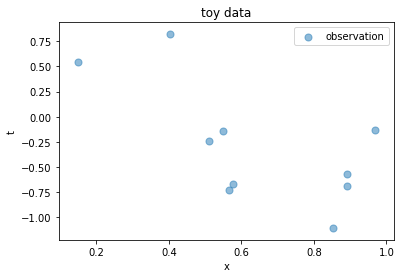

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_toy_data(func1, low=0, high=1, size=10, sigma=1.):
    x = np.random.uniform(low, high, size)
    t = func1(x) + np.random.normal(scale=sigma, size=size)
    return x, t

def func1(x):
    return np.sin(2 * np.pi * x)

x, t = create_toy_data(func1, low=0, high=1, size=10, sigma=0.25)
plt.scatter(x, t, s=50, marker='o', alpha=0.5, label="observation")

plt.legend()
plt.title("toy data")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

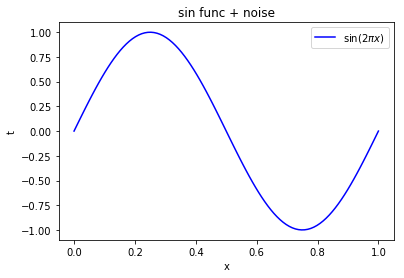

In [8]:
# テストデータのプロット
x_test = np.linspace(0, 1, 100)
plt.plot(x_test, func1(x_test), color='blue', label="sin($2\pi x$)")

plt.legend(loc="best")
plt.title("sin func + noise")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

今回は、関数 $sin(2πx)$  にノイズを加えて生成したデータ点(青点)<br>
からベイズ曲線フィッティングを行って予測してみます。

## 2. design matrix の計算

\begin{equation*}
{\bf\Phi} =  
\begin{bmatrix} 
\phi_0(x_0) & \phi_1(x_0) & \cdots & \phi_{M-1}(x_0)\\ 
\phi_0(x_1) & \phi_1(x_1) & \cdots & \phi_{M-1}(x_1)\\ 
\vdots & \vdots & \ddots & \vdots\\ 
\phi_0(x_{N-1}) & \phi_1(x_{N-1}) & \cdots & \phi_{M-1}(x_{N-1})\\ 
\end{bmatrix}
\end{equation*}

多項式回帰ですので　$ϕ_i(x)=x_i$ としています。<br>
この計画行列 $Φ$ は一つの行が一つの特徴ベクトルに対応します。

特徴ベクトル $ϕ(x)$ はここでは横方向と対応しています。

In [2]:
class PolynomialFeatures(object):

    def __init__(self, degree):
        self.degree = degree

    def transform(self, x):
        features = [x ** i for i in range(self.degree + 1)]
        return np.array(features).transpose()

numpy.transpose
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.transpose.html

<pre>
> x = np.arange(4).reshape((2,2))
> x
array([[0, 1],
       [2, 3]])
       
> np.transpose(x)
array([[0, 2],
       [1, 3]])
</pre>

In [3]:
features = PolynomialFeatures(degree=5)
X = features.transform(x)
X

array([[  1.00000000e+00,   5.11275156e-01,   2.61402285e-01,
          1.33648494e-01,   6.83311547e-02,   3.49360218e-02],
       [  1.00000000e+00,   1.49230432e-01,   2.22697217e-02,
          3.32332019e-03,   4.95940506e-04,   7.40094158e-05],
       [  1.00000000e+00,   5.65369564e-01,   3.19642744e-01,
          1.80716279e-01,   1.02171484e-01,   5.77646471e-02],
       [  1.00000000e+00,   8.52007601e-01,   7.25916953e-01,
          6.18486762e-01,   5.26955422e-01,   4.48970025e-01],
       [  1.00000000e+00,   9.67145640e-01,   9.35370689e-01,
          9.04639683e-01,   8.74918325e-01,   8.46173443e-01],
       [  1.00000000e+00,   4.02360601e-01,   1.61894053e-01,
          6.51397885e-02,   2.62096845e-02,   1.05457444e-02],
       [  1.00000000e+00,   8.90161772e-01,   7.92387980e-01,
          7.05353489e-01,   6.27878712e-01,   5.58913626e-01],
       [  1.00000000e+00,   5.75663319e-01,   3.31388257e-01,
          1.90768064e-01,   1.09818177e-01,   6.32182962e-02],


## 3. ベイズ曲線フィッティングの推定と予測

まずパラメータ $w$ の事後分布を推定します。

\begin{equation*}
p({\bf w}|{\bf x}, {\bf t}, \alpha, \beta) \propto p({\bf t}|{\bf\Phi}{\bf w}, \beta)p({\bf w}|\alpha)
\end{equation*}

ここで $x,t$ はトレーニングセットとしています。<br>
また、右辺の $p$ はどちらもガウス関数を仮定していて精度パラメータをそれぞれ $α$ と $β$ としています。<br>
すると左辺の確率分布もガウス分布となります。

\begin{equation*}
p({\bf w}|{\bf x}, {\bf t}, \alpha, \beta) = \mathcal{N}({\bf m}, {\bf S})
\end{equation*}

ただし、$m$:平均, $S$:標準偏差
\begin{equation*}
{\bf m} = \beta{\bf S}{\bf\Phi}^{\rm T}{\bf t},  \tag{1} 
\end{equation*}
\begin{equation*}
~{\bf S}^{-1} = \alpha{\bf I} + \beta{\bf\Phi}^{\rm T}{\bf\Phi}  \tag{2} 
\end{equation*}

この事後分布を用いて新しい点$x$ についての $t$ の確率分布は
\begin{equation*}
p(t | x,{\bf x}, {\bf t}, \alpha, \beta) = \int p(t|x,{\bf w},\beta)p({\bf w}|{\bf x}, {\bf t}, \alpha, \beta){\rm d}{\bf w}
\end{equation*}

これもまた計算するとガウス分布になっています。

\begin{equation*}
p(t | x,{\bf x}, {\bf t}, \alpha, \beta) = \mathcal{N}(t | {\bf m}^{\rm T}{\bf\phi}(x), {1\over\beta}+{\bf\phi}(x)^{\rm T}{\bf S}{\bf\phi}(x))
\end{equation*}


In [1]:
class BayesianRegression(object):

    def __init__(self, alpha=0.1, beta=0.25):
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, t):
        # 式1 平均
        self.w_mean = self.beta * self.w_var.dot(X.T.dot(t))
        # 式2 標準偏差
        self.w_var = np.linalg.inv( self.alpha * np.identity(np.size(X, 1))+ self.beta * X.T.dot(X))

    def predict(self, X):
        y = X.dot(self.w_mean)
        y_var = 1 / self.beta + np.sum(X.dot(self.w_var) * X, axis=1)
        y_std = np.sqrt(y_var)
        return y, y_std

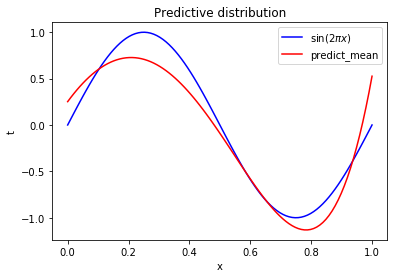

In [5]:
# パラメータの推定
regressor = BayesianRegression(alpha=1e-3, beta=2)
regressor.fit(X, t)

# テストデータの生成
x_test = np.linspace(0, 1, 100)
X_test = features.transform(x_test)

# テストデータで予測
y, y_std = regressor.predict(X_test)

# テストデータのプロット
plt.plot(x_test, func1(x_test), color='blue', label="sin($2\pi x$)")
# 予測値のプロット
plt.plot(x_test, y, color='red', label="predict_mean")

plt.legend(loc="best")
plt.title("Predictive distribution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

## 4. 予測誤差のプロット

予測分布の各 $x$ での平均値を赤線、標準偏差をピンクで表しています。<br>
ピンクの帯の幅がその予測の不確かさに対応しています。

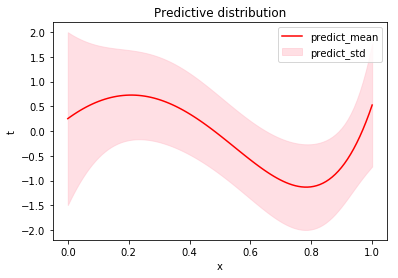

In [6]:
# 予測値
plt.plot(x_test, y, color='red', label="predict_mean")
# 予測値±標準偏差　分を表示
plt.fill_between(x_test, y - y_std, y + y_std,
                 color='pink', alpha=0.5, label="predict_std")
plt.legend()
plt.title("Predictive distribution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

## 5. 全体のコード

おおまかな流れは

1. トレーニングデータの作成(x, t = create_toy_data(func, ...))
2. 重みパラメータwwの事後分布を計算(regression.fit(X, t))
3. 事後分布を使って予測分布を計算(y, y_std = regression.predict(X_test))
4. 結果を図示

となっています。

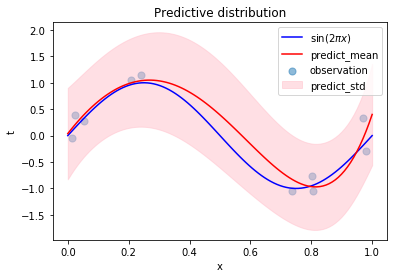

In [7]:
import matplotlib.pyplot as plt
import numpy as np


class PolynomialFeatures(object):

    def __init__(self, degree):
        self.degree = degree

    def transform(self, x):
        features = [x ** i for i in range(self.degree + 1)]
        return np.array(features).transpose()


class BayesianRegression(object):

    def __init__(self, alpha=0.1, beta=0.25):
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, t):
        self.w_var = np.linalg.inv(
            self.alpha * np.identity(np.size(X, 1))
            + self.beta * X.T.dot(X))
        self.w_mean = self.beta * self.w_var.dot(X.T.dot(t))

    def predict(self, X):
        y = X.dot(self.w_mean)
        y_var = 1 / self.beta + np.sum(X.dot(self.w_var) * X, axis=1)
        y_std = np.sqrt(y_var)
        return y, y_std


def create_toy_data(func1, low=0, high=1, size=10, sigma=1.):
    x = np.random.uniform(low, high, size)
    t = func1(x) + np.random.normal(scale=sigma, size=size)
    return x, t


def main():

    def func1(x):
        return np.sin(2 * np.pi * x)

    x, t = create_toy_data(func1, low=0, high=1, size=10, sigma=0.25)
    plt.scatter(x, t, s=50, marker='o', alpha=0.5, label="observation")

    features = PolynomialFeatures(degree=5)
    X = features.transform(x)

    # パラメータの推定
    regressor = BayesianRegression(alpha=1e-3, beta=2)
    regressor.fit(X, t)

    # テストデータの生成
    x_test = np.linspace(0, 1, 100)
    X_test = features.transform(x_test)
    
    # テストデータで予測
    y, y_std = regressor.predict(X_test)

    # 関数  sin(2πx)  にノイズを加えて生成したデータ点
    plt.plot(x_test, func1(x_test), color='blue', label="sin($2\pi x$)")
    
    # 予測値
    plt.plot(x_test, y, color='red', label="predict_mean")
    # 予測値±標準偏差　分を表示
    plt.fill_between(x_test, y - y_std, y + y_std,
                     color='pink', alpha=0.5, label="predict_std")
    plt.legend()
    plt.title("Predictive distribution")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()


main()    
#if __name__ == '__main__':
#    main()

関数 $sin(2πx)$ にノイズを加えて生成したデータ点(青点)からベイズ曲線フィッティングを行って予測しました。

ピンクの帯の幅がその予測の不確かさに対応していました。

もし、最尤推定による予測分布を計算した場合、<span style="color:red">ピンクの帯の幅は $x$ に依らず一定</span>となり、<br>
どの点の予測も同様に不確かという直感に合わない結果となってしまいます。

今回の結果では、予測に比較的自信がない領域はあまり観測点が少ない区間かと思いきや、<br>
<span style="color:red">観測点の多少と標準偏差の大小に相関はない</span>結果となっています。

また、このような挙動は特徴ベクトルにどのようなものを用いるのかにも依存してきます。

今回は多項式の特徴を用いましたが、他にもガウス関数を用いた特徴もよく用いられています。